In [57]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import load_data, clean_data, feature_engineer

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from scipy.stats import randint
from sklearn import preprocessing
from sklearn.tree import plot_tree

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# load data
pickle_raw = load_data(path = 'data/Pickleball - Sheet1.csv')

In [6]:
# clean data
pickle_clean = clean_data(pickle_raw)

/Users/jharwood/Desktop/pickleball-app/backend/utils.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_data.court_time = pd.to_datetime(clean_data.court_time)
/Users/jharwood/Desktop/pickleball-app/backend/utils.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_data.game_end_times = pd.to_datetime(clean_data.game_end_times)


In [7]:
# create features
pickle = feature_engineer(pickle_clean)

In [8]:
pickle.head()

1,Day,Park,Court,court_time,game_num,Player_A_1,Player_A_2,Paddle,Player_B_1,Player_B_2,Paddle2,game_length,becca_start,year,becca_win
2,Sunday,Plummer Park,6B,2025-01-12 14:00:00,1,Julianna,Alex,Straight,Becca,Justin,Bisexual,0 days 00:38:00,False,2023,True
3,Sunday,Plummer Park,6B,2025-01-12 14:00:00,2,Julianna,Alex,Straight,Becca,Stig,Bisexual,0 days 00:53:00,False,2023,False
4,Tuesday,Roxbury Tennis Club,2,2025-01-12 18:00:00,1,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:26:00,True,2023,True
5,Tuesday,Roxbury Tennis Club,2,2025-01-12 18:00:00,2,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:10:00,True,2023,True
6,Tuesday,Roxbury Tennis Club,2,2025-01-12 18:00:00,3,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:21:00,True,2023,False


In [10]:
pickle_new = pickle.copy()

In [11]:
pickle_new['game_length_mins'] = pickle_new.game_length.dt.total_seconds()/60

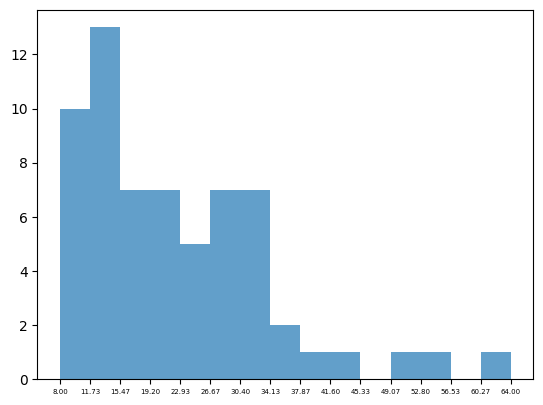

In [12]:
n, bins, edges = plt.hist(pickle_new.game_length_mins, bins=15, ec="red", alpha=0.7)
plt.xticks(bins, fontsize=5)
plt.show()

In [13]:
np.percentile(pickle_new.game_length_mins, 66)

np.float64(26.0)

In [14]:
pickle_new['game_length_bin'] = np.select([pickle_new.game_length_mins <= 14, pickle_new.game_length_mins < 30], 
                        [1, 2], 
                        default=3)

In [15]:
pickle_new = pickle_new.drop('game_length', axis = 1)

In [16]:
pickle_new['hour'] = pickle_new.court_time.dt.hour

In [17]:
pickle_new.head

<bound method NDFrame.head of 1         Day                    Park Court          court_time  game_num  \
2      Sunday            Plummer Park    6B 2025-01-12 14:00:00         1   
3      Sunday            Plummer Park    6B 2025-01-12 14:00:00         2   
4     Tuesday     Roxbury Tennis Club     2 2025-01-12 18:00:00         1   
5     Tuesday     Roxbury Tennis Club     2 2025-01-12 18:00:00         2   
6     Tuesday     Roxbury Tennis Club     2 2025-01-12 18:00:00         3   
..        ...                     ...   ...                 ...       ...   
101    Monday  La Ciénaga Tennis Club     3 2025-01-12 21:00:00         1   
103    Monday  La Ciénaga Tennis Club     3 2025-01-12 21:00:00         2   
104  Saturday  La Ciénaga Tennis Club     6 2025-01-12 21:00:00         1   
105  Saturday  La Ciénaga Tennis Club     6 2025-01-12 21:00:00         2   
106  Saturday  La Ciénaga Tennis Club     6 2025-01-12 21:00:00         3   

1   Player_A_1 Player_A_2    Paddle Player_B_

In [36]:
pickle_new = pickle_new[['game_num','Player_A_2','Player_B_2','becca_start','becca_win']]

In [37]:
pickle_new.head()

1,game_num,Player_A_2,Player_B_2,becca_start,becca_win
2,1,Alex,Justin,False,True
3,2,Alex,Stig,False,False
4,1,None,None,True,True
5,2,None,None,True,True
6,3,None,None,True,False


In [38]:
pickle_dummies = pd.get_dummies(pickle_new)

In [39]:
pickle_dummies

,game_num,becca_start,becca_win,Player_A_2_Alex,Player_A_2_None,Player_A_2_Taylor,Player_A_2_Tori,Player_B_2_Alex,Player_B_2_Justin,Player_B_2_None,Player_B_2_Stig,Player_B_2_Tay,Player_B_2_Taylor,Player_B_2_Tori
2,1,False,True,True,False,False,False,False,True,False,False,False,False,False
3,2,False,False,True,False,False,False,False,False,False,True,False,False,False
4,1,True,True,False,True,False,False,False,False,True,False,False,False,False
5,2,True,True,False,True,False,False,False,False,True,False,False,False,False
6,3,True,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1,False,False,False,True,False,False,False,False,True,False,False,False,False
103,2,False,False,False,True,False,False,False,False,False,False,False,False,True
104,1,False,True,False,True,False,False,False,False,True,False,False,False,False
105,2,True,False,False,True,False,False,False,False,True,False,False,False,False


In [40]:
X = pickle_dummies.drop('becca_win', axis=1)
y = pickle_dummies['becca_win']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [41]:
X_train

,game_num,becca_start,Player_A_2_Alex,Player_A_2_None,Player_A_2_Taylor,Player_A_2_Tori,Player_B_2_Alex,Player_B_2_Justin,Player_B_2_None,Player_B_2_Stig,Player_B_2_Tay,Player_B_2_Taylor,Player_B_2_Tori
104,1,False,False,True,False,False,False,False,True,False,False,False,False
71,1,False,False,True,False,False,False,False,True,False,False,False,False
9,1,False,False,True,False,False,False,False,False,False,False,True,False
50,2,True,False,False,False,True,False,False,False,False,False,True,False
38,2,False,False,False,True,False,False,False,False,False,False,False,True
7,4,False,False,True,False,False,False,False,True,False,False,False,False
22,1,False,False,True,False,False,False,False,True,False,False,False,False
23,2,False,False,True,False,False,False,False,True,False,False,False,False
74,4,True,False,True,False,False,False,False,True,False,False,False,False
73,3,False,False,True,False,False,False,False,True,False,False,False,False


In [49]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 1000],  # Number of trees in the forest
    'max_depth': [1,2,3,4],  # Maximum depth of the trees
    # 'min_samples_split': [2, 3, 4, 5, 6],  # Minimum number of samples required to split a node
    # 'min_samples_leaf': [1, 3, 5]  # Minimum number of samples required at each leaf node
}

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state = 42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 1000]},
             scoring='accuracy')

In [50]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_
test_accuracy = best_rf.score(X_test, y_test)
# y_pred = rf.predict(X_test)
print("Accuracy:", test_accuracy)

{'max_depth': 1, 'n_estimators': 1000}
Accuracy: 0.6153846153846154


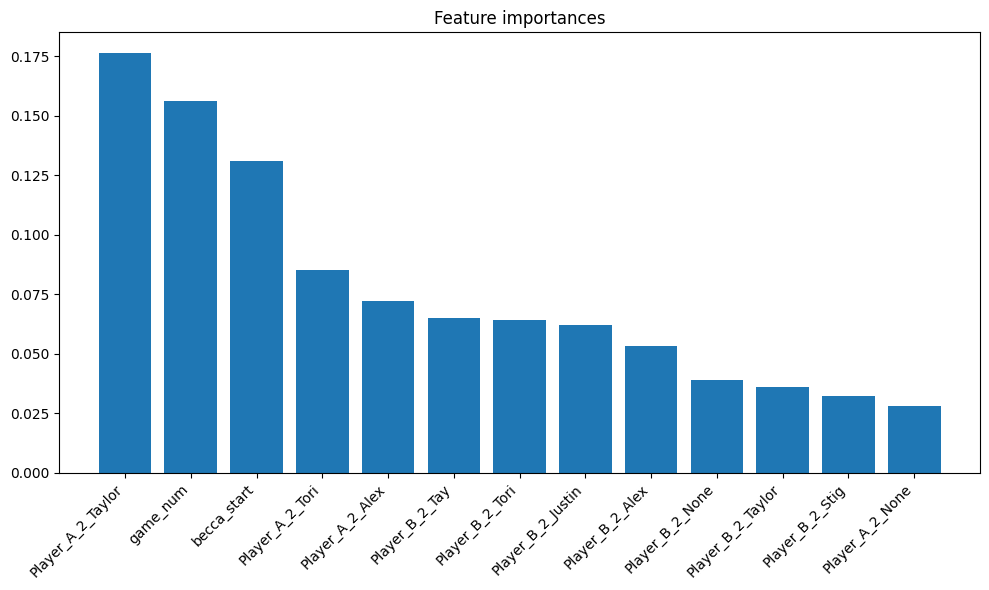

In [51]:
# Visualize variable importance

# Get feature importances
importances = best_rf.feature_importances_
features = X.columns.tolist()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align = "center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation = 45, ha = "right")
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


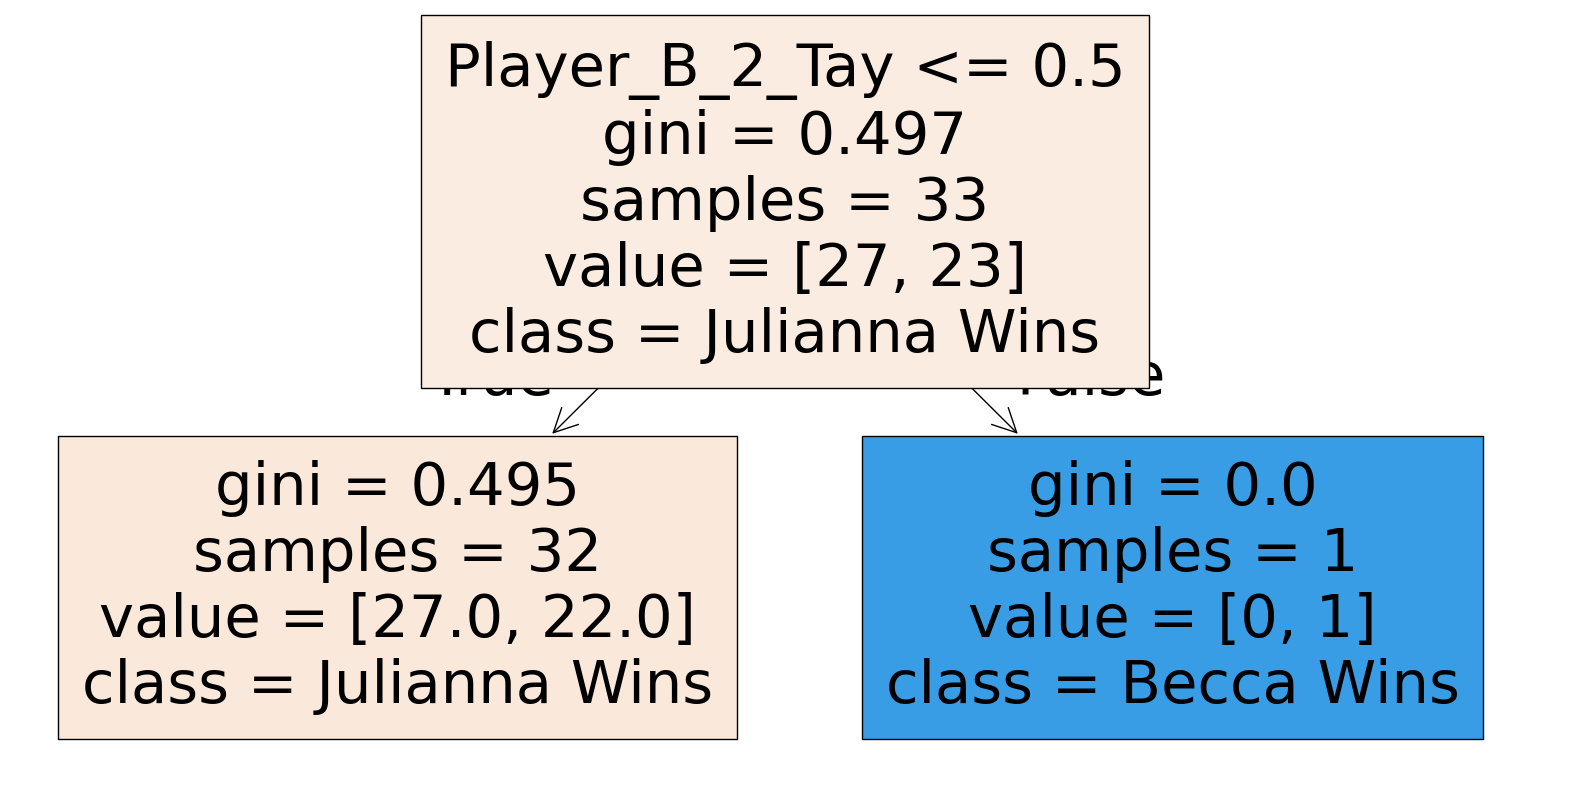

In [52]:
# Visualize a single decision tree from the forest
plt.figure(figsize = (20, 10))
plot_tree(best_rf.estimators_[14], feature_names = features,
          class_names = ['Julianna Wins','Becca Wins'], 
          filled = True)
plt.show()

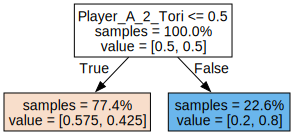

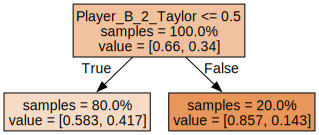

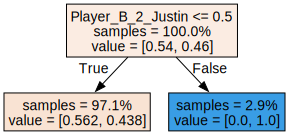

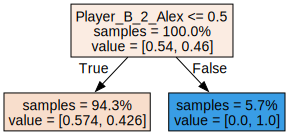

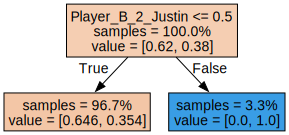

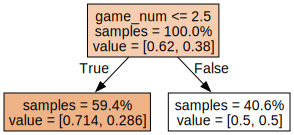

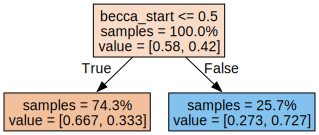

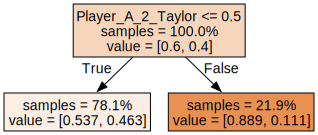

In [53]:
for i in range(8):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
#                                max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [58]:
import joblib

# Save the best model to a file
joblib.dump(best_rf, 'models/rf.joblib')

['models/rf.joblib']